# Telco Customer Churn: Exploratory Data Analysis (EDA)

**Date:** 2025-11-08    
**Author:** *Luis Renteria Lezano*

## Executive Summary
- **Goal:** Understand the key factors influencing customer churn (whether a customer leaves or stays) to prepare clean, structured data suitable for building baseline and advanced classification models.
- **Source:** This analysis uses the *Telco Customer Churn* dataset published by [IBM Cognos Analytics](https://www.ibm.com/docs/en/cognos-analytics/12.1.x?topic=samples-telco-customer-churn) or in the [IBM Official Repository](https://public.dhe.ibm.com/software/data/sw-library/cognos/mobile/C11/data/?C=M;O=D).
- **Data:** Multiple `.xlsx` files stored in `../data/raw/`, including:
  - `Telco_customer_churn.xlsx`  
  - `Telco_customer_churn_demographics.xlsx`  
  - `Telco_customer_churn_location.xlsx`  
  - `Telco_customer_churn_population.xlsx`  
  - `Telco_customer_churn_services.xlsx`  
  - `Telco_customer_churn_status.xlsx`
- **Target variable:** `Churn Label` (Yes = customer left, No = customer retained)
- **Objective:** Identify and understand relationships between demographics, service usage, contract type, billing, and churn behavior. This EDA will guide feature engineering and model development in later notebooks.

## 0. Reproducibility & Environment Setup
- Pin versions in `../requirements.txt`.
- Keep raw data immutable `../data/raw/`.
- Write cleaned/derived data to `../data/interim/`.
- Export final tables to `../reports/tables/` and figures to `../reports/figures/EDA`.

In [145]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Reproducibility
SEED = 42
np.random.seed(SEED)

# Paths
DATA_RAW = Path("../data/raw")
DATA_INTERIM = Path("../data/interim")
REPORTS_TABLES = Path("../reports/tables")
REPORTS_FIGURES = Path("../reports/figures/EDA")

# Create directories if missing
for folder in [DATA_RAW, DATA_INTERIM, REPORTS_TABLES, REPORTS_FIGURES]:
    folder.mkdir(parents=True, exist_ok=True)

plt.rcParams.update({
    "figure.figsize": (10, 5),
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "axes.facecolor": "#fafafa",
    "grid.alpha": 0.3
})
sns.set_theme(style='whitegrid', palette='colorblind', context='notebook')
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 17)   
pd.set_option('display.max_colwidth', 15)

print("Folder statuses:")
for d in [DATA_RAW, DATA_INTERIM, REPORTS_TABLES, REPORTS_FIGURES]:
    print(f"\t{d.resolve()} - {'Ready' if d.exists() else 'Missing'}")
print("> Environment setup completed.")

Folder statuses:
	/home/luisml/projects/github-repos/telco-churn-prediction/data/raw - Ready
	/home/luisml/projects/github-repos/telco-churn-prediction/data/interim - Ready
	/home/luisml/projects/github-repos/telco-churn-prediction/reports/tables - Ready
	/home/luisml/projects/github-repos/telco-churn-prediction/reports/figures/EDA - Ready
> Environment setup completed.


## 1. Introduction

This notebook performs an Exploratory Data Analysis (EDA) of the Telco Customer Churn dataset published by IBM Cognos Analytics (2025), in order to understand customer churn behavior, data quality, and the key relationships between demographic, service, and financial variables that influence whether a client leaves or stays.

**Columns available:**

* **Target:**  
`Churn Label` (Yes/No)  
`Churn Value` (1/0)

**General customer and service overview: `Telco_customer_churn.xlsx`**  
`CustomerID`, `Count`, `Country`, `State`, `City`, `Zip Code`, `Lat Long`, `Latitude`, `Longitude`, `Gender`, `Senior Citizen`, `Partner`, `Dependents`, `Tenure Months`, `Phone Service`, `Multiple Lines`, `Internet Service`, `Online Security`, `Online Backup`, `Device Protection`, `Tech Support`, `Streaming TV`, `Streaming Movies`, `Contract`, `Paperless Billing`, `Payment Method`, `Monthly Charges`, `Total Charges`, `Churn Label`, `Churn Value`, `Churn Score`, `CLTV`, `Churn Reason`.

**Demographic profile: `Telco_customer_churn_demographics.xlsx`**  
`Customer ID`, `Count`, `Gender`, `Age`, `Under 30`, `Senior Citizen`, `Married`, `Dependents`, `Number of Dependents`.

**Detailed service usage and billing: `Telco_customer_churn_services.xlsx`**  
`Service ID`, `Customer ID`, `Count`, `Quarter`, `Referred a Friend`, `Number of Referrals`, `Tenure in Months`, `Offer`, `Phone Service`, `Avg Monthly Long Distance Charges`, `Multiple Lines`, `Internet Service`, `Internet Type`, `Avg Monthly GB Download`, `Online Security`, `Online Backup`, `Device Protection Plan`, `Premium Tech Support`, `Streaming TV`, `Streaming Movies`, `Streaming Music`, `Unlimited Data`, `Contract`, `Paperless Billing`, `Payment Method`, `Monthly Charge`, `Total Charges`, `Total Refunds`, `Total Extra Data Charges`, `Total Long Distance Charges`, `Total Revenue`.

**Customer satisfaction and churn outcomes: `Telco_customer_churn_status.xlsx`**  
`Status ID`, `Customer ID`, `Count`, `Quarter`, `Satisfaction Score`, `Customer Status`, `Churn Label`, `Churn Value`, `Churn Score`, `CLTV`, `Churn Category`, `Churn Reason`.

**Geographic and spatial attributes: `Telco_customer_churn_location.xlsx`**  
`Location ID`, `Customer ID`, `Count`, `Country`, `State`, `City`, `Zip Code`, `Lat Long`, `Latitude`, `Longitude`.

**External demographic context (aggregated by ZIP Code): `Telco_customer_churn_population.xlsx`**  
`ID`, `Zip Code`, `Population`.

> This project uses only **`Telco_customer_churn_demographics.xlsx`**, **`Telco_customer_churn_services.xlsx`**, and **`Telco_customer_churn_status.xlsx`**, which contain all key demographic, service, and churn outcome data for modeling.
> 
> The main **`Telco_customer_churn.xlsx`** is excluded because it’s a pre-aggregated dashboard file duplicating information from the others.


**Purpose of this EDA:**

* Understand the structure, completeness, and relationships within all six data sources.
* Evaluate data quality, missing values, and type consistency across datasets.
* Explore demographic and behavioral patterns associated with customer churn.
* Identify key service, contract, and satisfaction features driving churn.
* Prepare a unified, feature-engineered dataset suitable for supervised classification models (e.g., Logistic Regression, RandomForest, Gradient Boosting).

## 2. Data Load, Merge & Overview
Data load, dtypes and basic checks.

In [146]:
df_churn_demographics = pd.read_excel(DATA_RAW / 'Telco_customer_churn_demographics.xlsx')
df_churn_services = pd.read_excel(DATA_RAW / 'Telco_customer_churn_services.xlsx')
df_churn_status = pd.read_excel(DATA_RAW / 'Telco_customer_churn_status.xlsx')

In [147]:
dfs = [df_churn_demographics, df_churn_services, df_churn_status]

# Dropping innecesary and count columns
cols_to_drop = ['Count', 'Quarter', 'ID', 'Service_ID', 'Status_ID']
for df in dfs:
    df.drop(columns=[c for c in cols_to_drop if c in df.columns], inplace=True, errors='ignore')
    
# Column names normalization
for df in dfs:
    df.columns = (df.columns.str.strip().str.replace(" ", "_").str.lower())
    df.rename(columns={"customerid": "customer_id"}, inplace=True)

# Column Merge
df_merged = pd.merge(df_churn_demographics, df_churn_services, on="customer_id", how="outer")  
df_merged = pd.merge(df_merged, df_churn_status, on="customer_id", how="outer")  
df_merged = df_merged.loc[:, ~df_merged.columns.duplicated()]
df = df_merged.copy()
print(f'This DataFrame contanis:\n- {df.shape[0]} rows\n- {df.shape[1]} columns')
df.head(3)

This DataFrame contanis:
- 7043 rows
- 45 columns


,customer_id,gender,age,under_30,senior_citizen,married,dependents,number_of_dependents,...,satisfaction_score,customer_status,churn_label,churn_value,churn_score,cltv,churn_category,churn_reason
0,0002-ORFBO,Female,37,No,No,Yes,No,0,...,3,Stayed,No,0,65,2205,NaN,NaN
1,0003-MKNFE,Male,46,No,No,No,No,0,...,5,Stayed,No,0,66,5414,NaN,NaN
2,0004-TLHLJ,Male,50,No,No,No,No,0,...,1,Churned,Yes,1,71,4479,Competitor,Competitor ...


In [148]:
# Dtypes and quick stats without showing all the 81 features. Use verbose=True to see it.
display(df.info(verbose=False))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Columns: 45 entries, customer_id to churn_reason
dtypes: float64(6), int64(10), object(29)
memory usage: 2.4+ MB


None

In [149]:
# First 10 numeric features description
df.describe().T.sort_index().head(10)

,count,mean,std,min,25%,50%,75%,max
age,7043.0,46.509726,16.750352,19.00,32.00,46.00,60.000,80.00
avg_monthly_gb_download,7043.0,20.515405,20.418940,0.00,3.00,17.00,27.000,85.00
avg_monthly_long_distance_charges,7043.0,22.958954,15.448113,0.00,9.21,22.89,36.395,49.99
churn_score,7043.0,58.505040,21.170031,5.00,40.00,61.00,75.500,96.00
churn_value,7043.0,0.265370,0.441561,0.00,0.00,0.00,1.000,1.00
cltv,7043.0,4400.295755,1183.057152,2003.00,3469.00,4527.00,5380.500,6500.00
monthly_charge,7043.0,64.761692,30.090047,18.25,35.50,70.35,89.850,118.75
number_of_dependents,7043.0,0.468692,0.962802,0.00,0.00,0.00,0.000,9.00
number_of_referrals,7043.0,1.951867,3.001199,0.00,0.00,0.00,3.000,11.00
satisfaction_score,7043.0,3.244924,1.201657,1.00,3.00,3.00,4.000,5.00


In [150]:
# First 10 categorical features description
df.drop(['customer_id', 'service_id', 'status_id'], axis=1).describe(include=['object']).T.sort_index().head(10)

,count,unique,top,freq
churn_category,1869,5,Competitor,841
churn_label,7043,2,No,5174
churn_reason,1869,20,Competitor ...,313
contract,7043,3,Month-to-Month,3610
customer_status,7043,3,Stayed,4720
dependents,7043,2,No,5416
device_protection_plan,7043,2,No,4621
gender,7043,2,Male,3555
internet_service,7043,2,Yes,5517
internet_type,5517,3,Fiber Optic,3035


## 3. Data Quality & Missing Values

>`satisfaction_score`, `churn_score` and `cltv` are leakage-prone features. They are made only for churned customers, making them unsuitable for training or evaluation. Dropping them ensures integrity.

In [151]:
df = df.drop(['churn_reason', 'churn_category', 'customer_status', 'churn_score', 'satisfaction_score', 'cltv'], axis=1).copy()
# All missing values
missing_values = df.isna().sum()[df.isna().sum() > 0].sort_values(ascending=False)
missing_values.head()

offer            3877
internet_type    1526
dtype: int64

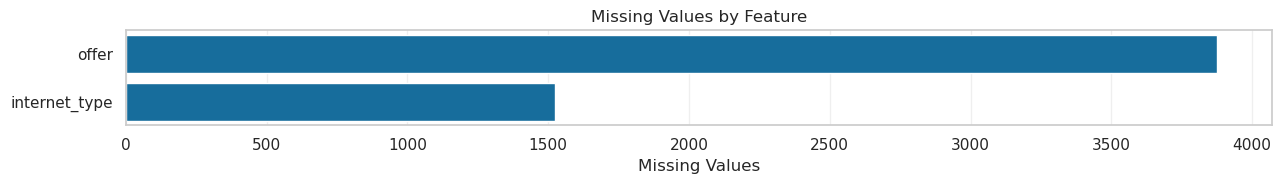

In [152]:
fig, ax = plt.subplots(figsize=(13, 2))
sns.barplot(x=missing_values.values, y=missing_values.index, ax=ax)
ax.set(title='Missing Values by Feature', xlabel='Missing Values', ylabel='')
plt.tight_layout()
plt.savefig(REPORTS_FIGURES / '01_missing_values.png', dpi=150)
plt.show()

## 4. Target Exploration

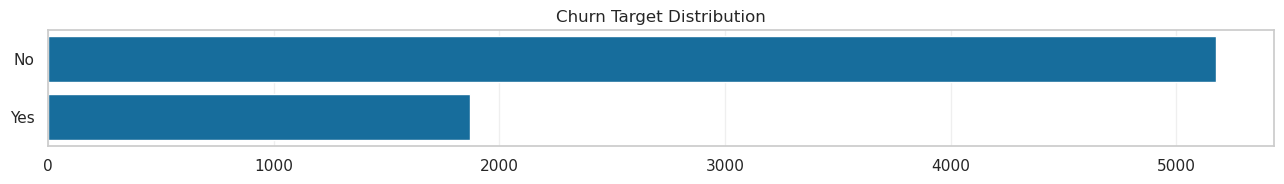

In [153]:
fig, ax = plt.subplots(figsize=(13, 2))
sns.countplot(data=df, y='churn_label')
ax.set(title='Churn Target Distribution', xlabel='', ylabel='')
plt.tight_layout()
plt.savefig(REPORTS_FIGURES / '02_target_distribution.png', dpi=150)
plt.show()

## 5. Univariate Exploration

### 5.1. Numerical Features

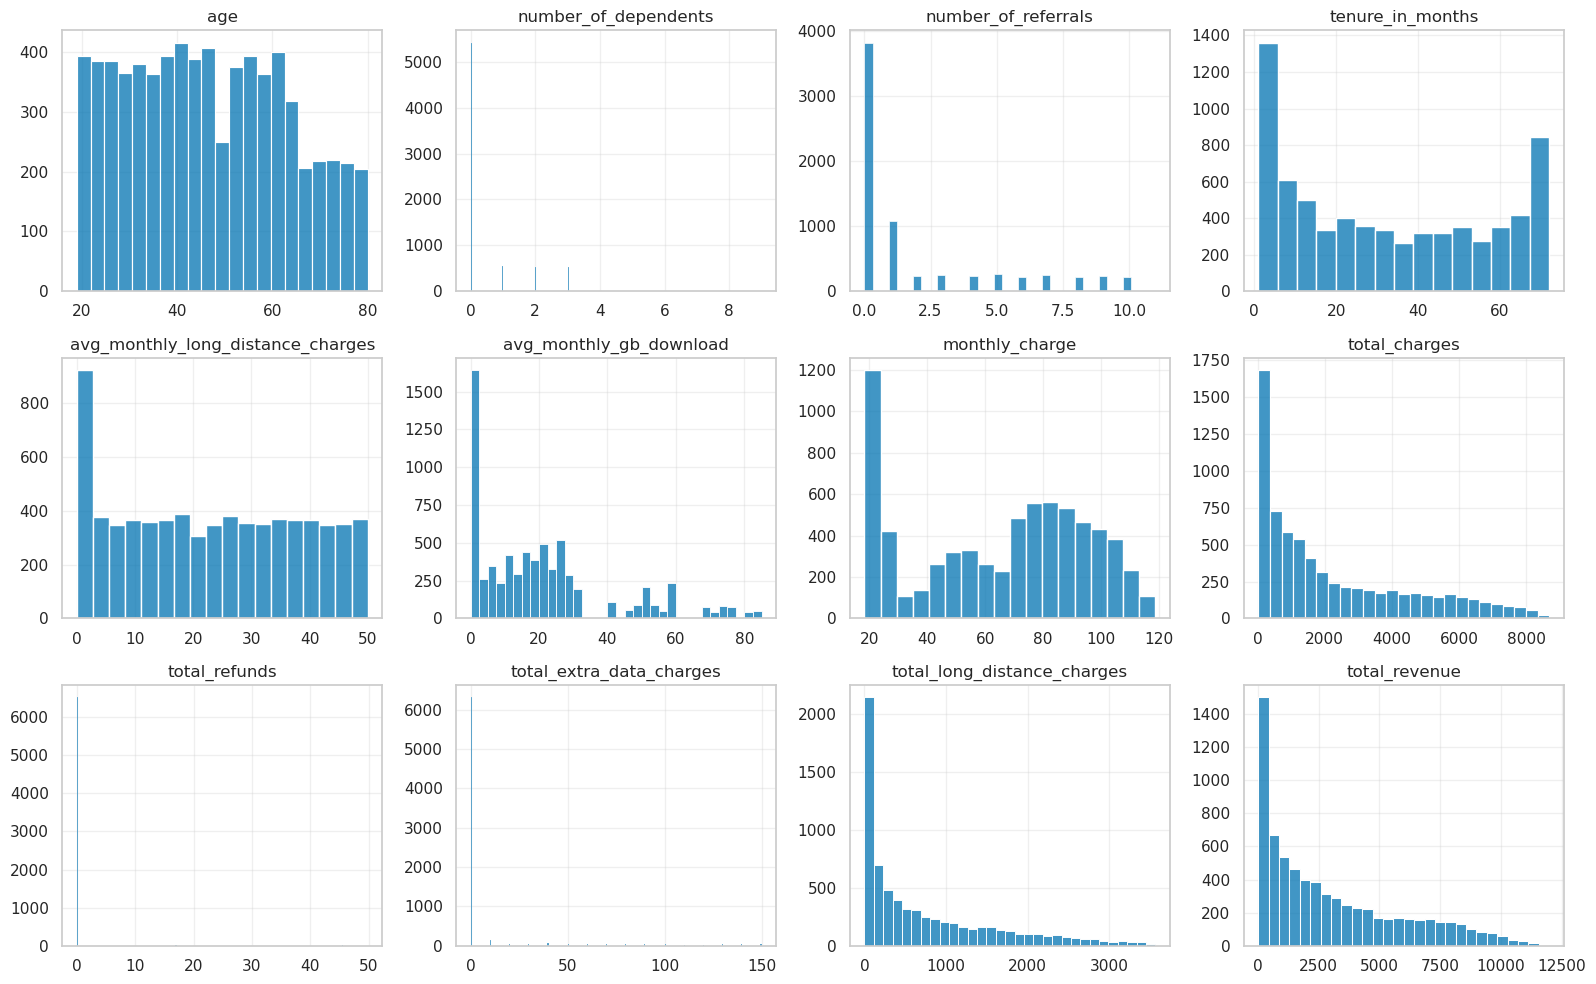

In [154]:
num_cols = df.drop('churn_value', axis=1).select_dtypes(['number', 'float64', 'int64']).columns

c = 0
fig, ax = plt.subplots(3, 4, figsize=(16,10))
for i in range(3):
    for j in range(4):
        if c >= len(num_cols):
            ax[i][j].set_visible(False)
            continue
        sns.histplot(data=df, x=num_cols[c], ax=ax[i][j])
        ax[i][j].set(title=num_cols[c], xlabel='', ylabel='')
        c += 1
    plt.tight_layout()
        
plt.savefig(REPORTS_FIGURES / '03_numeric_feat_distribution.png', dpi=150)
plt.show()

### 5.2. Categorical Features

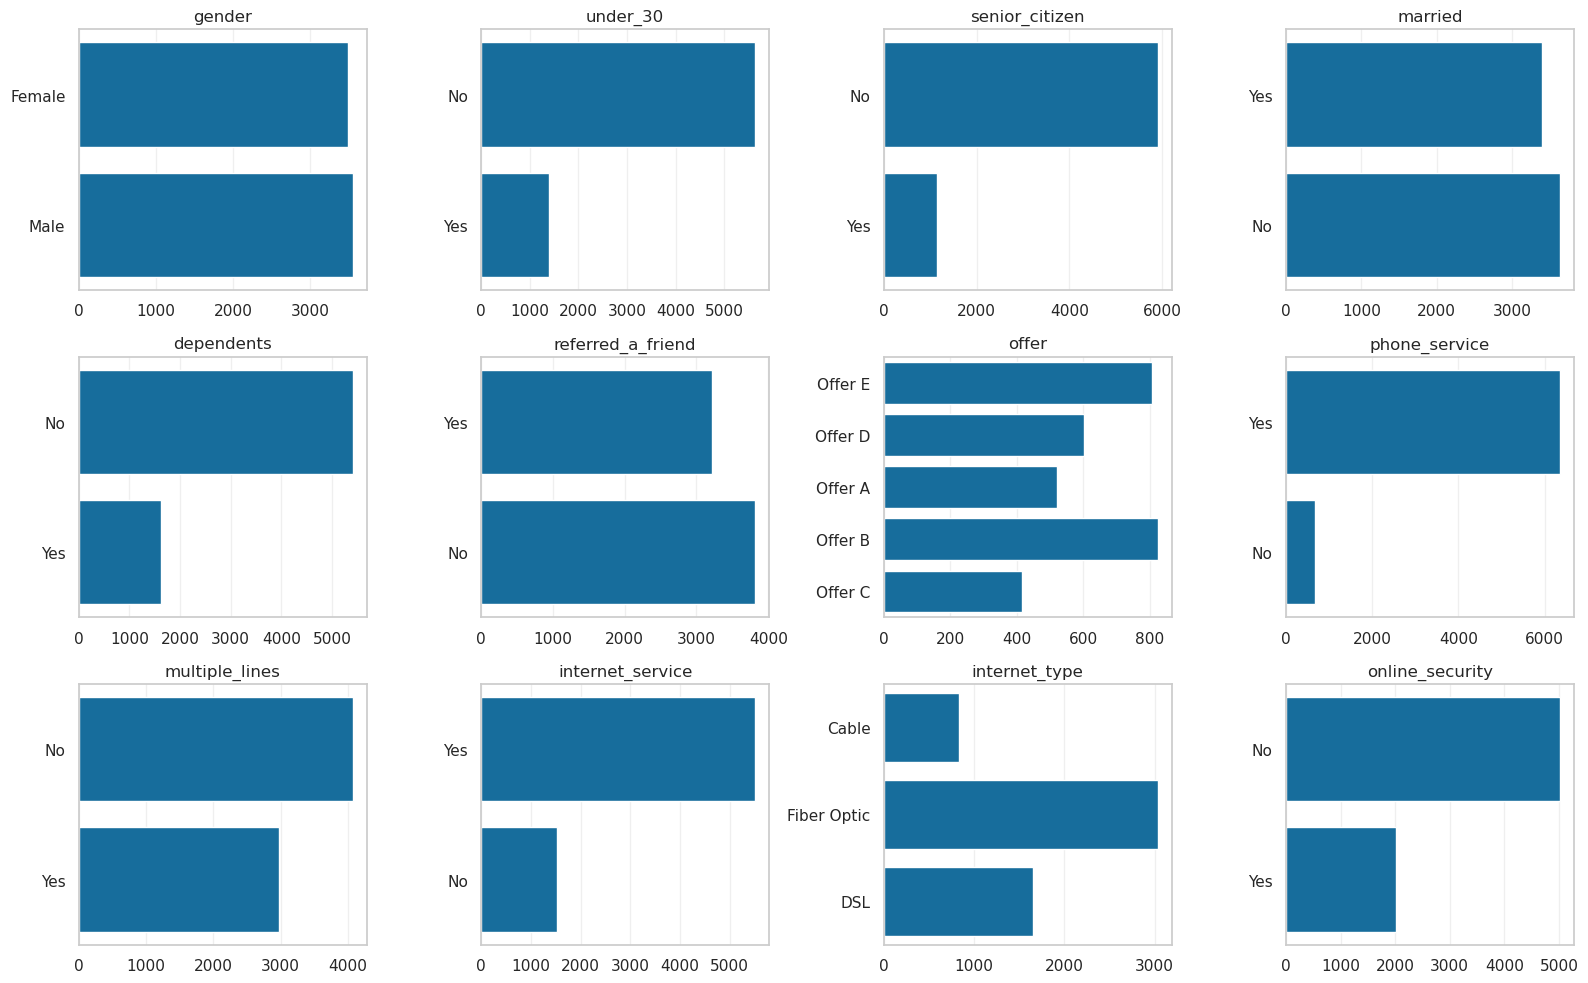

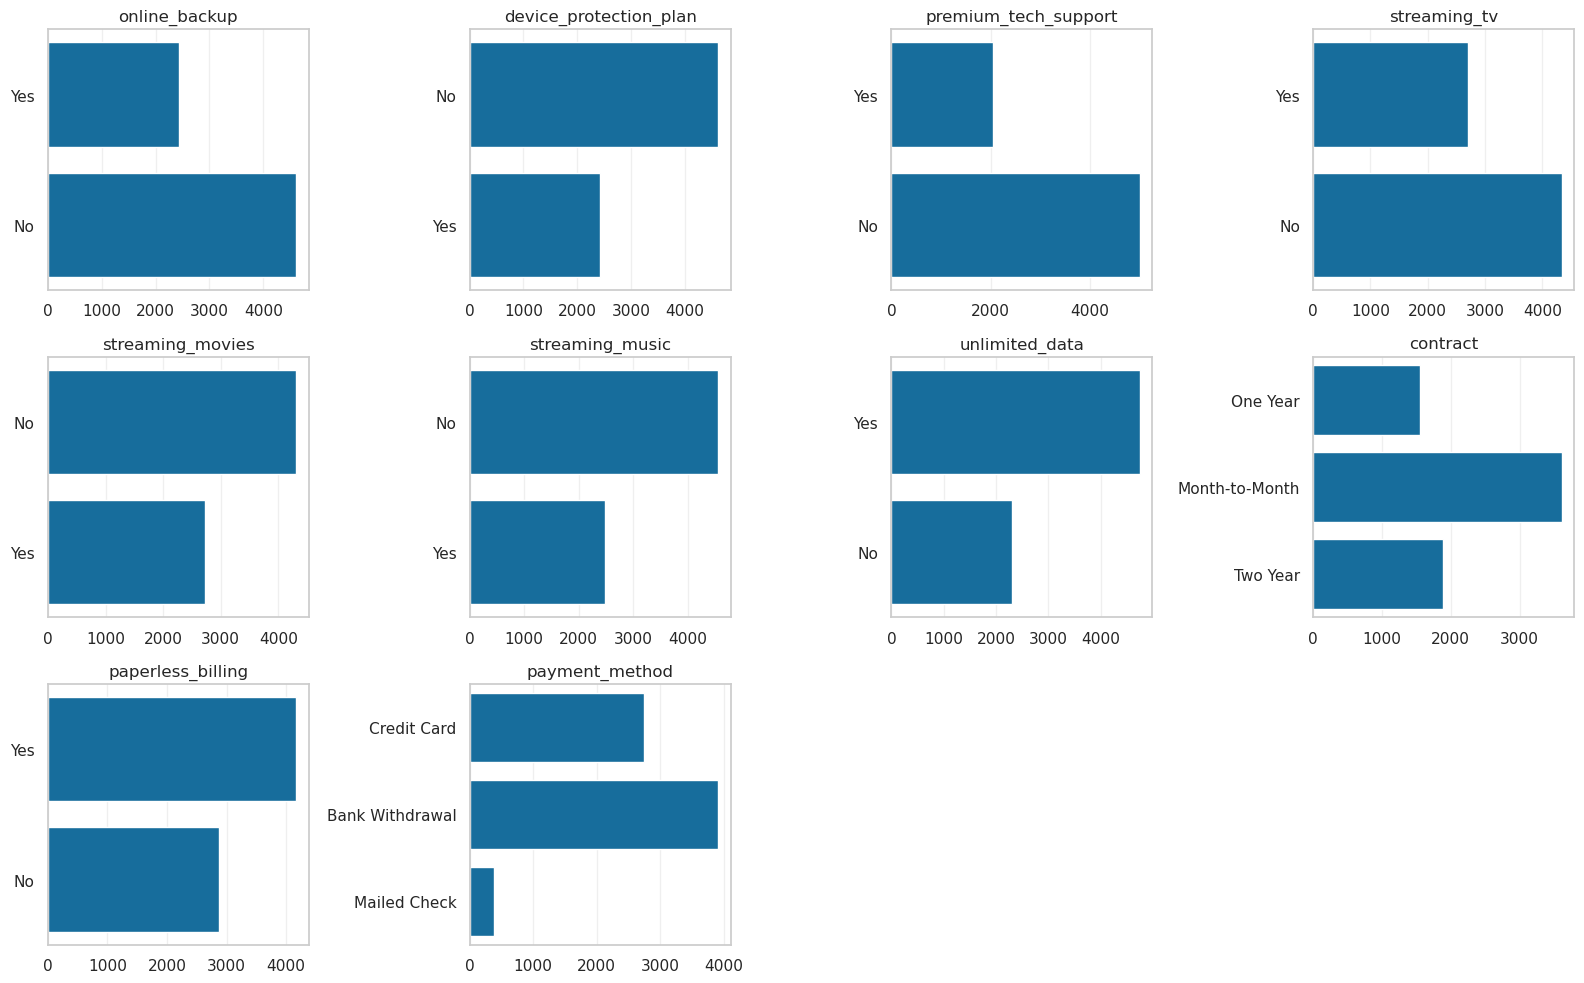

In [155]:
cat_cols = df.drop(['churn_label', 'customer_id', 'status_id', 'service_id'], axis=1).select_dtypes(['object']).columns

c = 0
for k in range(2):
    fig, ax = plt.subplots(3, 4, figsize=(16,10))
    for i in range(3):
        for j in range(4):
            if c >= len(cat_cols):
                ax[i][j].set_visible(False)
                continue
            sns.countplot(data=df, y=cat_cols[c], ax=ax[i][j])
            ax[i][j].set(title=cat_cols[c], xlabel='', ylabel='')
            c += 1
    plt.tight_layout()    
    plt.savefig(REPORTS_FIGURES / f'04_categorical_feat_distribution_{k}.png', dpi=150)
plt.show()

## 6. Bivariate Exploration

### 6.1. Numerical Features

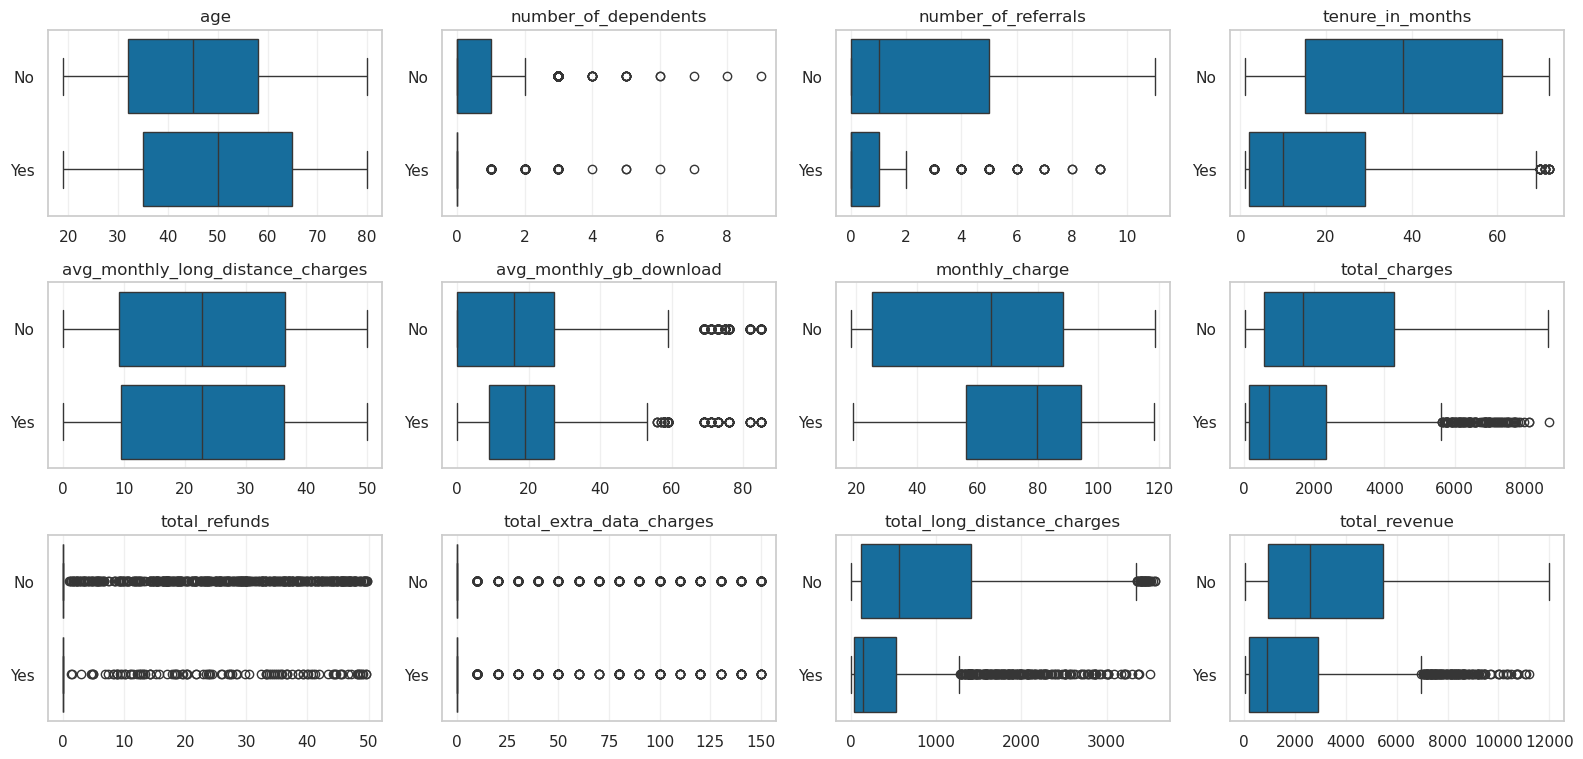

In [156]:
fig, ax = plt.subplots(4, 4, figsize=(16,10))
c = 0
for i in range(4):
    for j in range(4):
        if c >= len(num_cols):
            ax[i][j].set_visible(False)
            continue
        sns.boxplot(data=df, x=num_cols[c], y='churn_label', ax=ax[i][j])
        ax[i][j].set(title=num_cols[c], xlabel='', ylabel='')
        c += 1
    plt.tight_layout()
    
plt.savefig(REPORTS_FIGURES / '05_numeric_vs_target.png', dpi=150)
plt.show()

### 6.2. Categorical Features

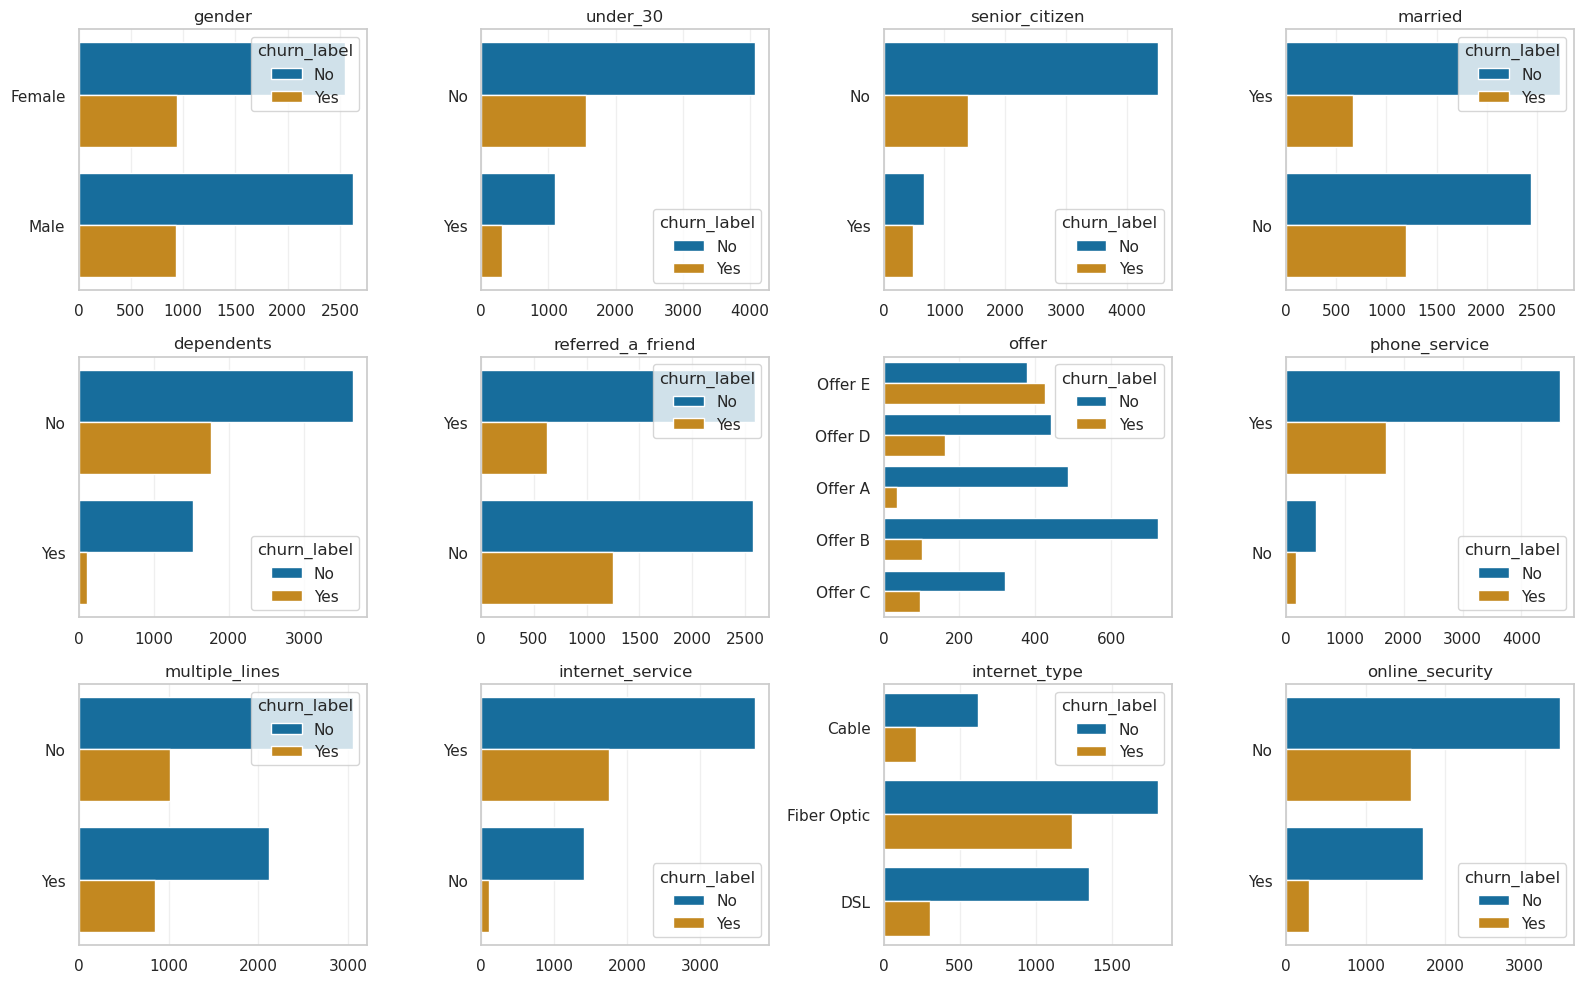

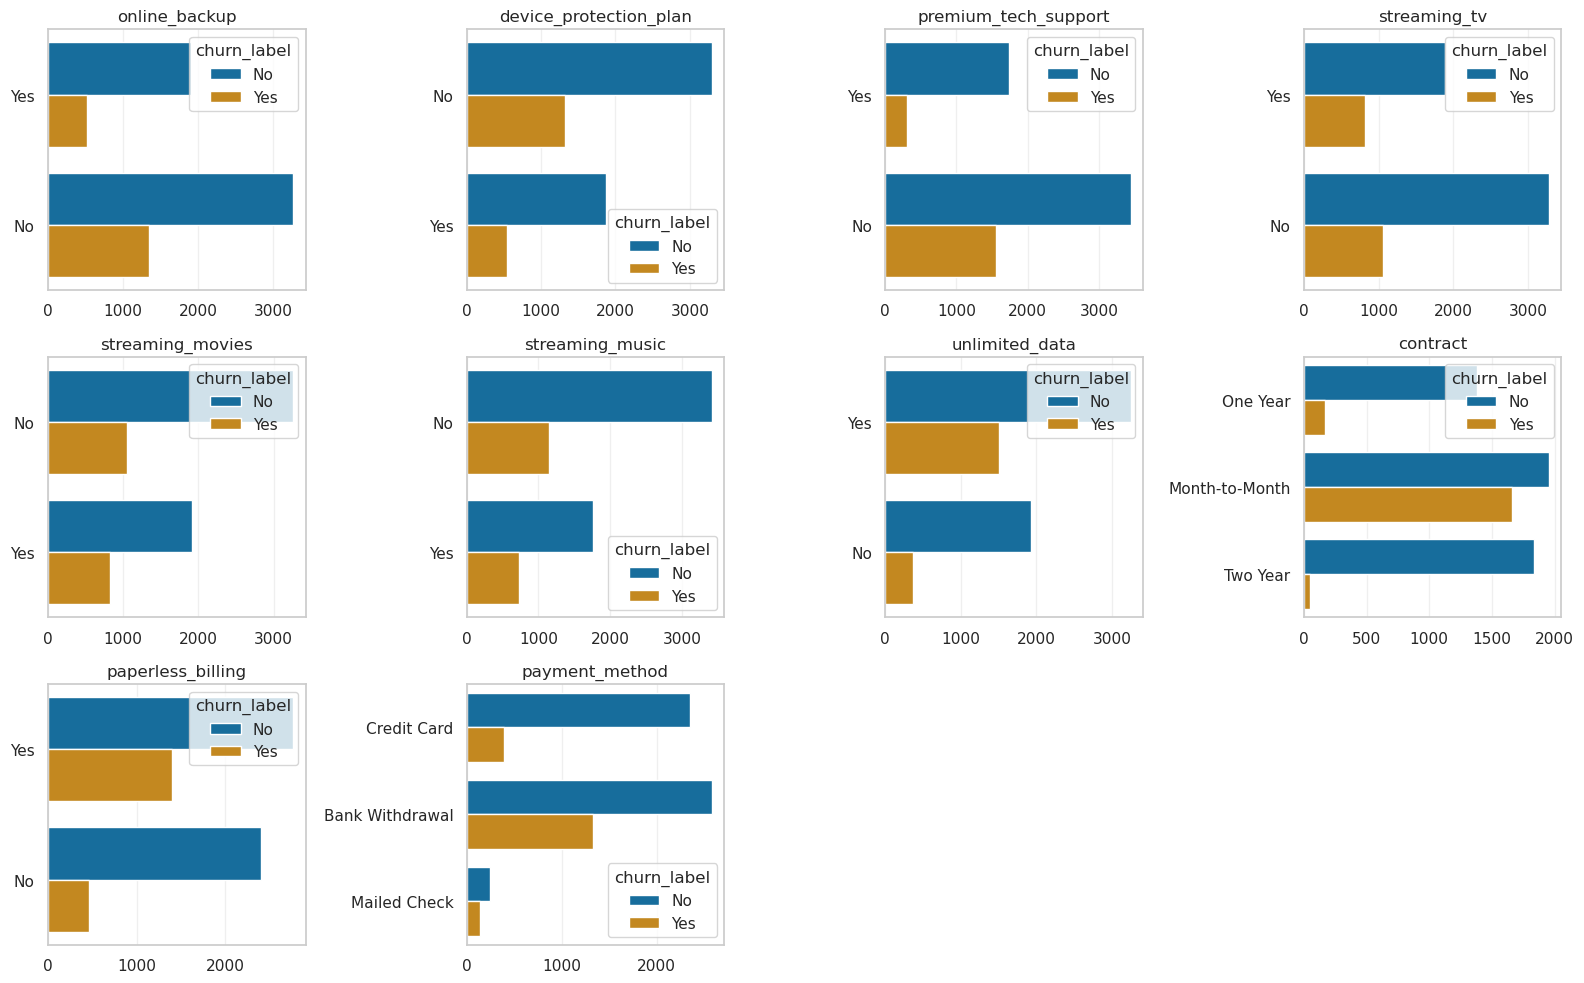

In [157]:
c = 0
for k in range(2):
    fig, ax = plt.subplots(3, 4, figsize=(16,10))
    for i in range(3):
        for j in range(4):
            if c >= len(cat_cols):
                ax[i][j].set_visible(False)
                continue
            sns.countplot(data=df, y=cat_cols[c], hue='churn_label', ax=ax[i][j])
            ax[i][j].set(title=cat_cols[c], xlabel='', ylabel='')
            c += 1
    plt.tight_layout()
    plt.savefig(REPORTS_FIGURES / f'06_categorical_vs_target_{k}.png', dpi=150)
plt.show()

## 7. Feature Engineering

In [158]:
# General feature engineering
df['avg_monthly_spending'] = df['total_charges'] / df['tenure_in_months']
df['revenue_minus_refunds'] = df['total_revenue'] - df['total_refunds']
df['age_group'] = pd.cut(df['age'], bins=[0,30,50,70,100], labels=['young','adult','senior','elder'])
df['contract_length_months'] = df['contract'].map({'Month-to-Month':1, 'One Year':12, 'Two Year':24})
df['has_streaming'] = df[['streaming_tv','streaming_movies','streaming_music']].eq('Yes').any(axis=1)

# Boolean features
df['is_under_30'] = (df['under_30'] == 'Yes').astype(int)
df['is_senior_citizen'] = (df['senior_citizen'] == 'Yes').astype(int)
df['is_married'] = (df['married'] == 'Yes').astype(int)
df['has_dependents'] = (df['dependents'] == 'Yes').astype(int)
df['has_referred_a_friend'] = (df['referred_a_friend'] == 'Yes').astype(int)
df['has_phone_service'] = (df['phone_service'] == 'Yes').astype(int)
df['has_multiple_lines'] = (df['multiple_lines'] == 'Yes').astype(int)
df['has_online_security'] = (df['online_security'] == 'Yes').astype(int)
df['has_online_backup'] = (df['online_backup'] == 'Yes').astype(int)
df['has_device_protection_plan'] = (df['device_protection_plan'] == 'Yes').astype(int)
df['has_premium_tech_support'] = (df['premium_tech_support'] == 'Yes').astype(int)
df['has_streaming_tv'] = (df['streaming_tv'] == 'Yes').astype(int)
df['has_streaming_movies'] = (df['streaming_movies'] == 'Yes').astype(int)
df['has_streaming_music'] = (df['streaming_music'] == 'Yes').astype(int)
df['has_unlimited_data'] = (df['unlimited_data'] == 'Yes').astype(int)
df['has_paperless_billing'] = (df['paperless_billing'] == 'Yes').astype(int)

# Total number of services feature:
binary_services = ['phone_service','internet_service','online_security','online_backup','device_protection_plan','premium_tech_support','streaming_tv','streaming_movies','streaming_music']
df['num_services'] = df[binary_services].eq('Yes').sum(axis=1)

## 8. Correlation Insights

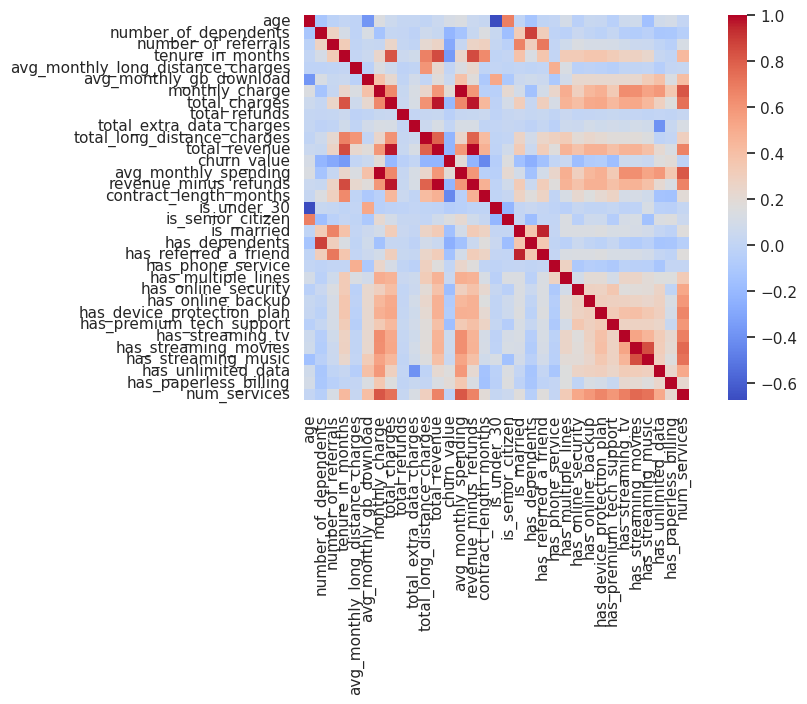

In [159]:
corr = df.select_dtypes(['number', 'float64', 'int64']).corr()
sns.heatmap(corr.fillna(0), cmap='coolwarm', square=True, xticklabels=True, yticklabels=True)
plt.savefig(REPORTS_FIGURES / f"07_correlation_map.png", dpi=150)
plt.show()

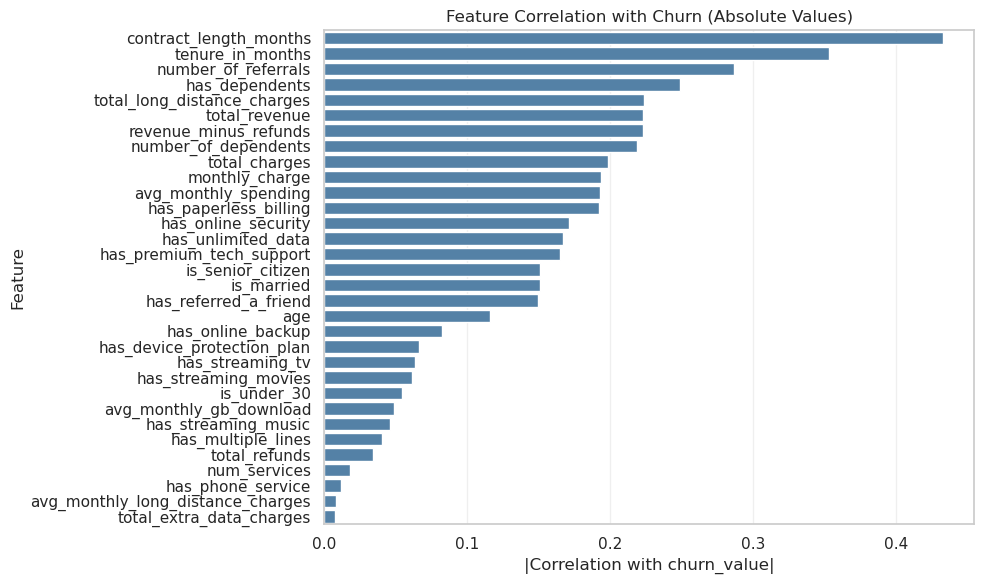

In [163]:
plt.figure(figsize=(10, 6))
sns.barplot(x=bar_corr[1:].values, y=bar_corr[1:].index, orient='h', color='steelblue')
plt.xlabel('|Correlation with churn_value|')
plt.ylabel('Feature')
plt.title('Feature Correlation with Churn (Absolute Values)')
plt.tight_layout()
plt.savefig(REPORTS_FIGURES / f'08_correlation_plot.png', dpi=150)
plt.show()